In [1]:
from pyopenms import *
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
def minutes_to_secs(input):
    output = input.split("m")
    output[1] = output[1].replace("s", "")
    return float(output[0]) * 60 + float(output[1])
   
def read_time(file_path, different_tools):
    out = np.zeros(different_tools)
    count = np.zeros(different_tools)
    with open(file_path, 'r') as file:
        tool = 0
        
        while content := file.readline():
            content.strip()
            if (content[0:4] == "real"):
                out[tool] += minutes_to_secs(content[4:])
                count[tool] += 1
                tool += 1
                if tool >= different_tools:
                    tool = 0
          
    for i in range(len(out)):
        out[i] = out[i]/count[i]
    return out

In [3]:
def read_time2(file_path):
    tools = []
    df = pd.DataFrame({"engine" : [], "dataset":[], "database":[], "time":[]})
    with open(file_path, 'r') as file:
        entry = False
        while content := file.readline():
            if content[0] == ">":
                s_content = content.strip().split(",")
                e = s_content[0][1:]
                ds= int(s_content[1])
                db= int(s_content[2])
                entry = True
            if entry and content[0:4] == "real":
                time = minutes_to_secs(content.strip()[4:])
                add_df = pd.DataFrame({"engine" : [e], "dataset":[ds], "database":[db], "time":[time]})
                df = pd.concat([df, add_df])
                entry = False
    return df
                
                

In [4]:
df = read_time2("temp_data/times/time_mesurements_Peptide_simple_sage.txt")
df = pd.concat([df, read_time2("temp_data/times/time_measurement_FIID_n3.txt")])
df['database_norm'] = (df['database']/df['database'].max()) * 10
df

,engine,dataset,database,time,database_norm
0,PSE,12.0,13256.0,153.486,3.344434
0,SSE,12.0,13256.0,199.218,3.344434
0,PSE,12.0,26182.0,166.257,6.605611
0,SSE,12.0,26182.0,237.648,6.605611
0,Sage,12.0,13256.0,63.768,3.344434
...,...,...,...,...,...
0,Sage,24.0,39636.0,160.502,10.000000
0,Sage,0.0,13256.0,3.321,3.344434
0,Sage,0.0,26182.0,4.845,6.605611
0,Sage,0.0,39636.0,8.163,10.000000


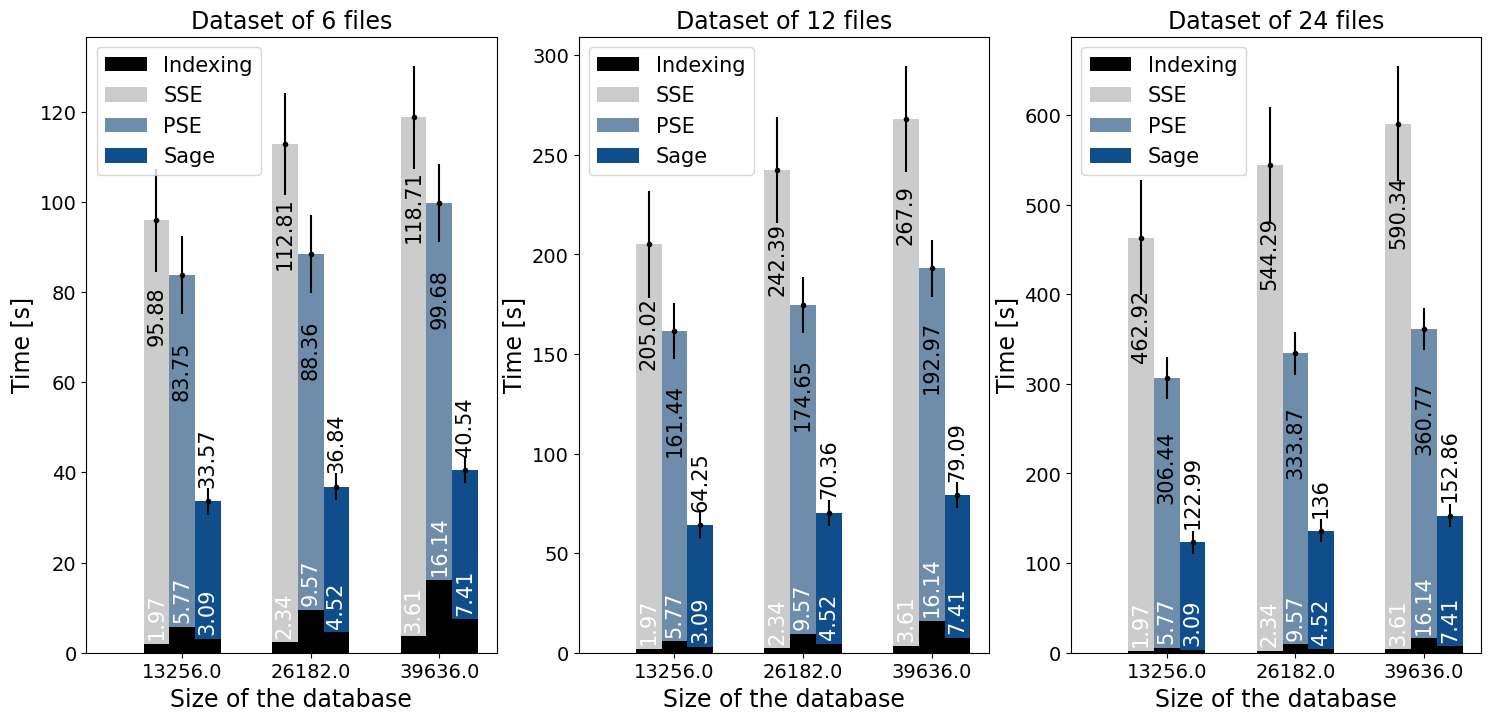

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8))

i=0
color_map = {"SSE":"#CCCCCC",'PSE': "#6E8DAB", 'Sage': "#104E8B" }
df_zero = df[df['dataset'] == 0]
for ds in [6,12,24]:
    df_temp = df[df["dataset"] == ds]
    width = 0.2
    counter = 0
    multiplier = 0
    axs[i].bar(0,0, color = "black", label = "Indexing")
    for engine in ['SSE', 'PSE', 'Sage']:
        
        x = np.arange(3)
        temp_zero = df_zero[df_zero['engine'] == engine]
        temp_zero = temp_zero.groupby('database')['time'].apply(lambda x: round(x.mean(),2))
        
        
        temp_e = df_temp[df_temp['engine'] == engine]
        temp_yerr = temp_e.groupby('dataset')['time'].apply(lambda x: np.std(x))
        temp_e = temp_e.groupby('database')['time'].apply(lambda x: round(x.mean(), 2)) 
        
        p = axs[i].bar(x + width * multiplier, temp_e, width, label = engine, color = color_map[engine])
        axs[i].errorbar(x + width * multiplier, temp_e, yerr = temp_yerr, fmt = '.', color = "black")
        
        a = axs[i].bar(x + width * multiplier, temp_zero, width, color = "black")
        
        if engine == "Sage":
            pad = 10
            
        else:
            pad = -90
           
        axs[i].bar_label(p, rotation = 90, padding = pad, size = 15)
        axs[i].bar_label(a, rotation = 90, padding = 3, color = "white", size = 15)
        multiplier += 1
    #df_s = df_temp[df_temp["engine"] == "SSE"]
    #df_p = df_temp[df_temp['engine'] == 'PSE']
    #df_sage = df_temp[df_temp['engine'] == 'Sage']
    
    #axs[i].bar(df_s["database_norm"]*1.5, df_s["time"], label = "SimpleSearchEngine")    
    #axs[i].bar(df_p["database_norm"]*1.5+1, df_p["time"], label = "PeptideSearchEngine") 
    #axs[i].bar(df_sage["database_norm"]*1.5+2, df_sage["time"], label = "Sage") 
    axs[i].tick_params(axis = 'both', which = 'major', labelsize = 14)
    axs[i].set_xticks(x + width, df['database'].unique())
    axs[i].set_xlabel('Size of the database', size = 17)
    axs[i].set_ylabel('Time [s]', size = 17)
    axs[i].set_title(f'Dataset of {ds} files', size = 17)
    axs[i].legend(fontsize = 15)
    i += 1
plt.savefig("Result_FIID_time.png", bbox_inches = 'tight', dpi = 500)


In [41]:
# next for open search

sage_open = [minutes_to_secs("7m34.775s"), minutes_to_secs("7m21.979s"), minutes_to_secs("7m15.895s"), minutes_to_secs("7m22.246s")]
pse_open = [minutes_to_secs("8m21.926s"), minutes_to_secs("8m12.045s"), minutes_to_secs("7m43.132s"), minutes_to_secs("7m55.136s")]

In [42]:
np.std(pse_open)

14.971398905496434

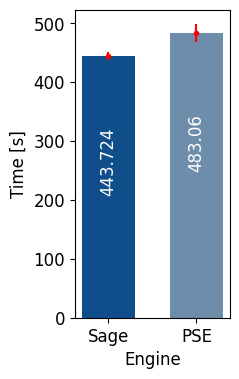

In [49]:
x = ["Sage", "PSE"]
y = [sum(sage_open)/len(sage_open), sum(pse_open)/len(pse_open)]
err = [np.std(sage_open), np.std(pse_open)]

plt.figure(figsize = (2,4))
p = plt.bar(x, y, width = 0.6, color = ["#104E8B", "#6E8DAB"])
plt.bar_label(p, rotation = 90, padding=-100, color = "w", size = 12)
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.xlabel("Engine", size = 12)
plt.ylabel("Time [s]", size = 12)
plt.errorbar(x, y, yerr =  err, fmt = ".", color = "r")
plt.savefig("FIID_open_time.png", bbox_inches = 'tight', dpi = 500)